<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Image Processing Laboratory Notebooks</h2>
<hr style="clear:both">
<p style="font-size:0.85em; margin:2px; text-align:justify">
This Juypter notebook is part of a series of computer laboratories which are designed
to teach image-processing programming; they are running on the EPFL's Noto server. They are the practical complement of the theoretical lectures of the EPFL's Master course <b>Image Processing II</b> 
(<a href="https://moodle.epfl.ch/course/view.php?id=463">MICRO-512</a>) taught by Dr. D. Sage, Dr. M. Liebling, Prof. M. Unser and Prof. D. Van de Ville.
</p>
<p style="font-size:0.85em; margin:2px; text-align:justify">
The project is funded by the Center for Digital Education and the School of Engineering. It is owned by the <a href="http://bigwww.epfl.ch/">Biomedical Imaging Group</a>. 
The distribution or the reproduction of the notebook is strictly prohibited without the written consent of the authors.  &copy; EPFL 2022.
</p>
<p style="font-size:0.85em; margin:0px"><b>Authors</b>: 
    <a href="mailto:pol.delaguilapla@epfl.ch">Pol del Aguila Pla</a>, 
    <a href="mailto:kay.lachler@epfl.ch">Kay Lächler</a>,
    <a href="mailto:alejandro.nogueronaramburu@epfl.ch">Alejandro Noguerón Arámburu</a>,
    <a href="mailto:daniel.sage@epfl.ch">Daniel Sage</a>, and
    <a href="mailto:kamil.seghrouchni@epfl.ch">Kamil Seghrouchni</a>.
     
</p>
<hr style="clear:both">
<h1>Lab 6.1: The wavelet transform</h1>
<div style="background-color:#F0F0F0;padding:4px">
    <p style="margin:4px;"><b>Released</b>: Thursday April 28, 2022</p>
    <p style="margin:4px;"><b>Submission</b>: <span style="color:red">Friday May 6, 2022</span> (before 11:59PM) on <a href="https://moodle.epfl.ch/course/view.php?id=463">Moodle</a></p>
    <p style="margin:4px;"><b>Grade weigth</b> (Lab 6, 17 points): 7.5 % of the overall grade</p>
    <p style="margin:4px;"><b>Remote help</b>: Monday May 2, 2022 on Zoom (12h-13h, see Moodle for link) and Thursday May 5, on campus</p>    
    <p style="margin:4px;"><b>Related lectures</b>: Chapter 8</p>
</div>

### Student Name: Guanqun LIU

### SCIPER: 334988

Double-click on this cell and fill your name and SCIPER number. Then, run the cell below to verify your identity in Noto and set the seed for random results.

In [29]:
import getpass
# This line recovers your camipro number to mark the images with your ID
uid = int(getpass.getuser().split('-')[2]) if len(getpass.getuser().split('-')) > 2 else ord(getpass.getuser()[0])
print(f'SCIPER: {uid}')

SCIPER: 334988


## <a name="imports_"></a> Imports
In the next cell we import standard Python libraries that we will use throughout the lab, as well as the following libraries that are required for the exercises:

* [`matplotlib.pyplot`](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.html), to display images,
* [`ipywidgets`](https://ipywidgets.readthedocs.io/en/latest/), to make the image display interactive,
* [`numpy`](https://numpy.org/doc/stable/reference/index.html), for mathematical operations on arrays,
* [OpenCV (`cv2`)](https://docs.opencv.org/2.4/index.html), for image processing tasks,
* [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html), for more image processing tasks,
* [PyWavelets (`pywt`)](https://pywavelets.readthedocs.io/en/latest/), to calculate wavelet transforms.

Moreover, we will import the `ImageViewer` class (Python package developed specifically for these laboratories, see documentation [here](https://github.com/Biomedical-Imaging-Group/interactive-kit/wiki/Image-Viewer), or run the python command `help(viewer)` after loading the class), created specifically for this course, which provides interactive image visualization based on the `ipywidgets` library.

As you can see, in this lab we will make an exception and import one library specific to the use of the wavelet transform, [PyWavelets](https://pywavelets.readthedocs.io/en/latest/). This is because this library gives us the most flexibility to work with the wavelet transform.

Run the following cell to import all of these libraries and load the images we will use throughout this notebook.

In [30]:
# Configure plotting as dynamic
%matplotlib widget

# Import standard required packages for this exercise
import matplotlib.pyplot as plt
import matplotlib
import ipywidgets as widgets
import scipy.ndimage as ndi
from scipy import signal
import numpy as np
import cv2 as cv 
import pywt
import time
from interactive_kit import imviewer as viewer
from scipy import stats
import math
import sys

# Load images to be used in this exercise 
doisneau = cv.imread('images/doisneau.tif', cv.IMREAD_UNCHANGED).astype('float64')
doisneau_noise = cv.imread('images/doisneau-noise.tif', cv.IMREAD_UNCHANGED).astype('float64')
lowlight = cv.imread('images/lowlight.tif', cv.IMREAD_UNCHANGED).astype('float64')
mer_de_glace = cv.imread('images/mer-de-glace.tif', cv.IMREAD_UNCHANGED).astype('float64')
lighthouse = cv.imread('images/lighthouse.tif', cv.IMREAD_UNCHANGED).astype('float64')

# The wavelet transform (9 points)

In this laboratory we propose to study a simple *wavelet transform*, the Haar wavelet transform, and experiment with its applications. Moreover, you will develop the understanding and tools to experiment with any discrete wavelet transform you want. Note that the wavelet transform is itself an application of filtering and downsampling. While we expect you to be familiar and comfortable implementing the fundamental blocks in a low-level language, the lab will be completely in Python to simplify most tasks and allow you to focus on the _new_ content. If you would like to review the low-level implementations of filtering and downsampling, feel free to have a look at [Lab 2: Filtering](Filtering.ipynb#-1.B.-Separable-version-(2-points)) and [Lab 1: Introductory](Introductory.ipynb(#-2.A.a.-NumPy)).

## <a id="ToC_1_WT"></a>Table of contents
1. [The Haar wavelet transform](#1.-The-Haar-wavelet-transform)
    1. [Boundary conditions](#1.A.-Boundary-conditions)
2. [Analysis](#2.-Analysis-(6-points))
    1. [Filterbank implementation - Analysis](#2.A.-Filterbank-implementation---Analysis-(3-points)) **(3 points)**
    2. [A note on the visualization of wavelet coefficients](#2.B.-A-note-on-the-visualization-of-wavelet-coefficients-(1-point)) **(1 point)**
    3. [Polyphase implementation of the Haar wavelet transform - Analysis](#2.C.-Polyphase-implementation-of-the-Haar-wavelet-transform---Analysis-(1-point)) **(1 point)**
    4. [PyWavelets - Analysis](#2.D.-PyWavelets---Analysis-(1-point)) **(1 point)**
3. [Synthesis](#3.-Synthesis-(3-points)) 
    1. [Filterbank implementation - Synthesis](#3.A.-Filterbank-implementation---Synthesis-(2-points)) **(2 points)**
    2. [Polyphase implementation of the Haar wavelet transform - Synthesis](#3.B-Polyphase-implementation-of-the-Haar-wavelet-transform---Synthesis-(1-point)) **(1 points)**
    4. [Synthesis with PyWavelets](#3.C.-Synthesis-with-PyWavelets)
    
The overall algorithmic structure of the wavelet transform's filterbank implementation for scale $n=2$ is shown in the following figure.

<img src="images/wavelet.png" alt="Drawing" style="width: 600px;"/>

### Visualize Images
Feel free to get familiar now with the images you are going to be using. Run the next cell and use `Next` / `Prev` to cycle through the images.

In [31]:
# Display images
image_list = [doisneau, doisneau_noise, lighthouse, mer_de_glace, lowlight]

plt.close('all')
imgs_viewer = viewer(image_list, widgets = True)

# 1. The Haar wavelet transform
[Back to table of contents](#ToC_1_WT)

In this section we propose to study the Haar wavelet transform. As the following figure illustrates, this transform approximates a signal as a sum of alternating-sign piecewise constant functions at different shifts and scales.

<img src="images/haar_showcase.png" alt="Drawing" style="width: 800px;"/>

Mathematically, this is just an example of what you have studied, where from a wavelet function $\psi(x)$, a collection of basis functions is obtained as

$$\psi_{i,k}(x) = 2^{-\frac{i}{2}}\psi\left(\frac{x}{2^i}-k\right)\,, \forall i \in \mathbb{N}, \forall k \in \mathbb{Z}\,,$$

and any signal $f(x)$ is expanded as

$$ f = \sum_{i \in \mathbb{N}}\sum_{k\in\mathbb{Z}} \left\langle f, \psi_{i,k}\right\rangle \psi_{i,k}\,.$$

In practical, discrete terms, this expansion is only applied up to a scale $i=n$, and for the shifts that are within the signal of interest.

The discrete transformation splits a discrete signal of size $m$ into two parts of size $m/2$ (say, for example, $1$ and $1'$). When applied iteratively, the low frequency signal ($1'$) is further split in into two parts (for example, $2$ and $2'$) of size $m/4$ and so on and so forth, as exemplified in the figure below for $n=3$.

<img src="images/split_2.png" alt="Drawing" style="width: 1200px;"/>

Here, the frequency division is an idealized drawing to convey the concept, while in practice wavelet functions are not necessarily very sharp in the frequency domain. 

In the case of images (2 dimensional signals), the wavelet transform can be applied in a separable way. To review the concept of separability, please refer to [Lab 2: Filtering](Filtering.ipynb#-1.B.-Separable-version-(2-points)) or to the [IP1](https://moodle.epfl.ch/course/view.php?id=522) course notes. Because the wavelet transform does decompose the signal in low and high frequency content as seen above, a separable application results in four different regions on the wavelet coefficients for each scale, referred to as 
 * *LL* for the low-frequency coefficients in both directions (typically placed in the upper-left corner),
 * *HL* for the high-frequency coefficients in the horizontal direction and low-frequency coefficients in the vertical direction (typically placed in the upper-right corner),
 * *LH* for the opposite of *HL* (typically placed in the lower-left corner), and
 * *HH* for the high-frequency coefficients in both directions (typically placed in the lower-right corner).
 
When several iterations of the wavelet are applied, each iteration has its associated regions (**there is only one LL region, however**). These regions are subscripted according to the iteration they belong to, as shown in the image below.

<img src="images/wavelet_orders.png" alt="Drawing" style="width: 350px;"/>

If `nx` and `ny` correspond to the size of the image in the $x$ and $y$ directions, respectively, each of the four regions are of size `nx/2`$\times$`ny/2`. Together, they form an image of the same size as the original, as exemplified by the figure below.

<img src="images/2dwt.png" alt="Drawing" style="width: 600px;"/>

## 1.A. Boundary conditions
[Back to table of contents](#ToC_1_WT)

In all the previous labs, we have used (and strongly recommended) *mirror* boundary conditions for applications in filtering (e.g., Gaussian smoothing or edge detection), which generally reduces boundary artifacts and results in images that are more pleasant to look at. However, when you apply a convolution with mirror or constant boundary conditions and you clip the output to have the same length as the input, some information about the original signal is lost. This does not matter in most filtering applications - for example, in Gaussian filtering for denoising or edge detection, you do not usually want to recover the original image. 

In contrast, in image *transforms* the inverse transform has a well defined meaning, and it is key for applications to be able to go back to the original domain without losing information. We do not care about how the signal looks **in the transform domain**, and we  **absolutely do not want any loss of information to occur, so that the original signal can be recovered**. This is why we use **periodic boundary conditions**. Intuitively, information *lost* in one boundary of an image is stored *on the other side of it*, and we can keep transforms of the same size as the original without losing any information. As a curiosity, using periodic boundary conditions (i.e., using circular convolutions), is exactly the same as filtering with the FFT of the same length of the signal. 

Look at the following example of a one-dimensional wavelet transform taken with a full mode convolution (i.e. keeping all the coefficients of the convolution). Note how, on one hand, when the boundary conditions are set to constant, we need the values from outside the region of the original signal (limited by the vertical red lines) for the reconstruction. While, on the other hand, when the boundary conditions are set to periodic, these values can be recovered from the other side of the signal, so we can have a wavelet transform of the exact same size as the signal. 

<table><tr>
<td>
  <p align="center" style="padding: 10px">
    <img alt="Routing" src="images/const_bound_wt.png" width="400"><br>
    <em style="color: grey">WT with full mode convolution and <b>constant</b> boundary conditions.</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img src="images/wrap_bound_wt.png" alt="Drawing" style="width: 400px;"/><br>
    <em style="color: grey">WT with full mode convolution and <b>periodic</b> boundary conditions.</em>
  </p> 
</td>
</tr></table>

In the following sections, you will first implement the general wavelet transform in its filterbank formulation, using standard *NumPy* and *SciPy* functions. The resulting functions will be parameterized so that by simply providing the correct filters, you can evaluate any wavelet transform. After that, you will also implement the Haar wavelet transform using the *polyphase implementation*, which is more efficient, but less general. Finally, we will test your implementations with respect to the library *PyWavelets*, and teach you how to use it.

<div class = 'alert alert-success'>
    
<b>Notes:</b> To get a completely correct implementation fo the direct and inverse wavelet transforms, you will have to go through several steps:
<ul>
<li> you will have to get 4 filters right,</li>
<li> you will have to implement two analysis functions (independent of each other, and only one of them dependent of the filters),</li>
<li> you will have to implement two synthesis functions, similar to the analysis. </li>
</ul>    
This is basically to say that the wavelet transform is a complex topic. However, we have designed <b>each section of the lab to be independent of the others</b>. For example, if you don't get the analysis function right, you will still be able to test the correctness of your synthesis, and we will grade them separately. 
    
So, do not get stuck too long in a single exercise, as you will always be able to continue with the lab.

</div>
    
<div class = 'alert alert-warning'>

<b>Hint:</b> A very common bug in this kind of lab is mixing up <code>nx</code> and <code>ny</code>. Some tests will be run in rectangular images, so you will catch the bug right away. However, some tests will also be done on square images, and you might miss this bug! Make sure to always make your own tests by creating cells wherever needed.
</div>

# 2. Analysis (6 points) 
[Back to table of contents](#ToC_1_WT)

The analysis or direct wavelet transform is equivalent to obtaining the coefficients $\left\langle f, \psi_{i,k}\right\rangle$ to express a signal $f$ in terms of the basis functions $\psi_{i,k}$. As you can see in the [block diagram](#Index) of the filterbank implementation (not in the notation of the course), the analysis is carried out by applying two filters, which in the notation of the course are
 * $\tilde{H}(z)$ for the low-pass filter, and 
 * $\tilde{G}(z)$ for the high-pass filter.
 
In this section you will first implement the analysis using the filterbank implementation. Then we will make a short parenthesis to study how one can best visualize the wavelet transform coefficients. You will then proceed to the polyphase implementation of the Haar wavelet transform. Finally, you will test both your implementations against the implementation of *PyWavelets*. 

## 2.A. Filterbank implementation - Analysis (3 points)
[Back to table of contents](#ToC_1_WT)

The filterbank implementation, during the analysis, uses two filters corresponding to a specific wavelet (highpass and lowpass filter), and consecutively applies the filtering and downsampling operations. Because this can be implemented very generically, the function you will now prepare will allow us to later experiment with different wavelets beyond Haar's. 

To begin this section, and **for 1 point,  write the impulse response of the four filters of the Haar filterbank (two for the analysis and two for the synthesis) in spatial domain (worth 0.25 each)**. As a hint, remember from the course notes that the filters to use for the Haar wavelet transform can be deduced from the following $\mathcal{Z}$-transform expression

$$H(z) = \frac{1 + z^{-1}}{\sqrt{2}}\,.$$

To answer, change the value of the variables `analysis_hp`, `analysis_lp`, `synthesis_hp` and `synthesis_lp`. If in doubt, go to your course notes (Chapter 8, 8-51). **Give your answer with the minimum odd support necessary to clearly show the center of the filter**, considering that the value in the center is always assigned to $n=0$. 

As an example, the variable `example` has been filled to implement the filter $E(z)=z-z^{-1}$, according to the reasoning in the table below, where $\uparrow$ indicates the coefficient corresponding to $n=0$.

| $E(z)$ | $e[n]$ | $\lbrace \dots, \underset{\uparrow}{\cdot}, \dots \rbrace$ | `example` | 
|--------|--------|-----------------------------------------------------|-----------|
| $z - z^{-1} $ | $\delta[n+1] -\delta[n-1]$ | $\lbrace \dots,0,1,\underset{\uparrow}{0},-1,0,\dots\rbrace$ | `np.array([1, 0, -1])` |

Here, $\delta[n]$ is the Kronecker delta centered at $0$. 

Run the cells below the next one to check that your answers are valid.

<div class = 'alert alert-danger'>
    
<b>Notes:</b> 
<ol>
<li> Give exact answers using NumPy functions or attributes (e.g., `np.pi` instead of 3.14159),</li>
<li> Give your answer as a NumPy Array (see `example` in the table above and in the next cell).</li>
</ol>
Both notes are meant to avoid problems with the precision of the calculation.   
</div>
<div class = 'alert alert-info'>
    
<b>Hint:</b> Which of the 4 filters corresponds to the one we just gave you? From $H(z)$ and your course notes you should be able to derive the other three.  
</div>

In [32]:
analysis_lp = np.array([1/np.sqrt(2), 1/np.sqrt(2), 0])
analysis_hp = np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0])
synthesis_lp = np.array([0, 1/np.sqrt(2), 1/np.sqrt(2)])
synthesis_hp = np.array([0, 1/np.sqrt(2), -1/np.sqrt(2)])
# As an example:
example = np.array([1, 0, -1])
# YOUR CODE HERE

In [33]:
# Sanity check for type...
if not type(analysis_lp) == np.ndarray: print('WARNING!!\nMake sure that you provide a NumPy array.')
# size ...
if not analysis_lp.size == 3: print('WARNING!!\nEven though the filters of the Haar wavelet have a support of 2\
                                    elements, you need 3 elements to specify the center of the filter.')
# and norm of your filters
if not np.isclose(np.linalg.norm(analysis_lp), 1): print('WARNING!!\nHint: all wavelet filters have a norm of 1.')

In [34]:
# Sanity check for type...
if not type(analysis_hp) == np.ndarray: print('WARNING!!\nMake sure that you provide a NumPy array.')
# size ...
if not analysis_hp.size == 3: print('WARNING!!\nEven though the filters of the Haar wavelet have a support of 2\
                                    elements, you need 3 elements to specify the center of the filter.')
# and norm of your filters
if not np.isclose(np.linalg.norm(analysis_hp), 1): print('WARNING!!\nHint: all wavelet filters have a norm of 1.')

In [35]:
# Sanity check for type...
if not type(synthesis_lp) == np.ndarray: print('WARNING!!\nMake sure that you provide a NumPy array.')
# size ...
if not synthesis_lp.size == 3: print('WARNING!!\nEven though the filters of the Haar wavelet have a support of 2\
                                    elements, you need 3 elements to specify the center of the filter.')
# and norm of your filters
if not np.isclose(np.linalg.norm(synthesis_lp), 1): print('WARNING!!\nHint: all wavelet filters have a norm of 1.')

In [36]:
# Sanity check for type...
if not type(synthesis_hp) == np.ndarray: print('WARNING!!\nMake sure that you provide a NumPy array.')
# size ...
if not synthesis_hp.size == 3: print('WARNING!!\nEven though the filters of the Haar wavelet have a support of 2\
                                    elements, you need 3 elements to specify the center of the filter.')
# and norm of your filters
if not np.isclose(np.linalg.norm(synthesis_hp), 1): print('WARNING!!\nHint: all wavelet filters have a norm of 1.')

<a id="filt_impl_anal"></a>Now, **for 2 points**, we suggest you complete the filterbank implementation of the analysis part of the wavelet transform in Python. For that, you will complete the function `analysis` below, which takes as parameters

* `data`: the original image,
* `lp`: the low-pass analysis filter,
* `hp`: the high-pass analysis filter,
* `n`: the number of iterations of the analysis filterbank to perform, i.e., the maximum _scale_ to be used.

The output is the wavelet transform, a 2D NumPy array of the same size as the original image.

Read the following hints **very carefully** to help you during the implementation.
 
<div class = 'alert alert-success'>
    
<b>Hints:</b>
    
<ol>
The structure of the function <code>analysis</code> is the following:
 <li>. We get information about the image size, and preallocate space for the output. </li>
 <li>. We repeat, a total of $n$ times:</li>
    <ol>
     <li>. Select the appropriate region of the image (initially the complete image, thereafter the <i>LL</i> coefficients of the previous iteration),</li>
     <li>. apply the low-pass filter horizontally,</li>
     <li>. apply the high-pass filter horizontally,</li>
     <li>. downsample both results,</li>
     <li>. construct the wavelet transform coefficients in the horizontal direction,</li>
     <li>. repeat steps B to E for the vertical direction on the wavelet coefficients that resulted from the horizontal analysis.</li>
</ol></ol>
     
Steps 1. and 2A. are already implemented for you. 
    
For steps 2.B and 2.C, <b>use the function <code>ndi.convolve1d</code></b>, implemented by SciPy in its multidimensional image processing module (<a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve1d.html#scipy.ndimage.convolve1d'>see documentation</a>) - this function applies a horizontal/vertical 1D convolution to all the rows/columns of an image simultaneously, which is why we use it instead of <a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html'><code>scipy.signal.convolve2d</code></a> (<b>which we will not accept</b>) as in <a href='#1.A.-Boundary-conditions'>section 1.A</a>. Moreover, <code>ndi.convolve1d</code> gives the result of the same size as the input, so you will not have to worry about the convolution mode.   
    
Some extra tips are:

<ul>
<li> <b>use periodic boundary conditions, i.e., (<code>mode = 'wrap'</code>)</b>,</li>
<li> to downsample, use <a href='https://numpy.org/doc/stable/reference/arrays.indexing.html'>NumPy slicing</a>. In particular, you might want to use the <code>[start:stop:step]</code> notation. In the next cell you will see an example where we downsample a $10\times 10$ array,</li>
<li> to <i>construct</i> the wavelet transform coefficients (i.e., join <i>L</i> and <i>H</i> coefficients as shown in the images in <a href="#1.-The-Haar-wavelet-transform" >Section 1</a>, use the <a href='https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html'><code>np.concatenate</code></a> function.</li>
<li> when calling each of these functions, be very careful with the <code>axis</code> parameter.</li>
</ul>
</div>

Run the next cell to see the example of downsampling, and complete the function `analysis` in the cell after that.

In [37]:
# Declare test image
test = np.arange(100).reshape((10,10))
print('Original array: \n', test)
# Downsampling in the horizontal direction
print('\n Horizontally downsampled array: \n', test[:, ::2])

Original array: 
 [[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]

 Horizontally downsampled array: 
 [[ 0  2  4  6  8]
 [10 12 14 16 18]
 [20 22 24 26 28]
 [30 32 34 36 38]
 [40 42 44 46 48]
 [50 52 54 56 58]
 [60 62 64 66 68]
 [70 72 74 76 78]
 [80 82 84 86 88]
 [90 92 94 96 98]]


In [38]:
# Function that performs n iterations of the analysis part of the wavelet transform on img
def analysis(img, lp, hp, n):
    # Get dimensions of the original image
    ny, nx = img.shape
    # Declare output
    output = np.copy(img)
    for i in range(n):
        # Get LL (will select the whole image the first time, and 
        # the LL part of the previous iteration the next times)
        sub = output[0:ny, 0:nx]
        
        # Store your result in the variable sub, which is incorporated
        # into output at the end of each iteration
        
        ## Horizontal transform
        # Apply filters to create the two horizontal components
        horizontal_lp = ndi.convolve1d(sub, weights=lp, mode='wrap', axis=1)
        horizontal_hp = ndi.convolve1d(sub, weights=hp, mode='wrap', axis=1)
        
        # Downsample
        horizontal_lp = horizontal_lp[:, ::2]
        horizontal_hp = horizontal_hp[:, ::2]
        
        # Concatenate results to construct horizontal wavelet structure
        sub = np.concatenate((horizontal_lp, horizontal_hp), axis=1)
        
        ## Vertical transform
        # Repeat all the steps above for the vertical transform
        vertical_lp = ndi.convolve1d(sub, weights=lp, mode='wrap', axis=0)
        vertical_hp = ndi.convolve1d(sub, weights=hp, mode='wrap', axis=0)
        
        vertical_lp = vertical_lp.T[:, ::2].T
        vertical_hp = vertical_hp.T[:, ::2].T
        
        sub = np.concatenate((vertical_lp, vertical_hp), axis=0)

        # Insert sub to replace the old LL coefficients
        output[0:ny, 0:nx] = sub
        # Adjust dimensions to represent the new LL coefficient
        nx = nx//2
        ny = ny//2
    return output

Now we will apply your function to the image `lowlight` with $n = 1$ and wth $n = 4$. Make sure that the results make sense.

In [39]:
# Now we apply the wavelet transform to the image lowlight
lowlight_wt_1 = analysis(lowlight, analysis_lp, analysis_hp, 1)
lowlight_wt_3 = analysis(lowlight, analysis_lp, analysis_hp, 3)
# Display the results
plt.close('all')
view = viewer([lowlight_wt_1, lowlight_wt_3], title = ['n = 1', 'n = 3'], widgets = True)

What do you think about the result? Let's apply your function to a rectangular image now. We will test on `mer_de_glace`.

In [40]:
mer_de_glace_wt_1 = analysis(mer_de_glace, analysis_lp, analysis_hp, 1)
mer_de_glace_wt_3 = analysis(mer_de_glace, analysis_lp, analysis_hp, 3)

rect_viewer = viewer([mer_de_glace_wt_1, mer_de_glace_wt_3], title = ['n = 1', 'n = 3'], widgets = True)

As you know we usually provide numerical tests for you to check your functions. We will do that after implementing the polyphase formulation later in the lab. In the meantime, let's move on to the next section.

## 2.B. A note on the visualization of wavelet coefficients (1 point)
[Back to table of contents](#ToC_1_WT)

As you probably just noticed, the contrast obtained when displaying the wavelet transform is not ideal. This is because the low frequency coefficients are almost always much larger than the high frequency coefficients. Many colormaps have been proposed to enhance the visualization of the wavelet transform. These colormaps, in general,

* treat the different regions of the wavelet transform (*LL*, *HL*, *LH*, *HH*) as independent images, and
* keep the $0$ value of the coefficients at the same level throughout the image.

In this section we will see two possible visualization techniques:

1. *Non-uniform mapping*: The negative values are linearly mapped to the range $[0, 127.5]$, and the positive values to $[127.5, 255]$. $0$ is mapped to $127.5$. This implies that positive and negative numbers are not treated equally (they go through different linear transformations).
2. *Normalized standard deviation mapping*: The image (or region) is normalized (scaled) so that it has a standard deviation of $1$. Because there is no translation, only a scaling factor, the $0$ of the original coefficients stays at the same level. Moreover, all pixels are clipped to the range $[\overline{x}-3\sigma, \overline{x}+3\sigma]$ (where $\overline{x}$ represents the sample mean of the data, and $\sigma$ its sample standard deviation) to avoid outliers that reduce overall contrast (note that this step can be implemented before or after normalization, to the same effect with the corresponding $\sigma$ values). Note that the mean is most probably not $0$, and will therefore change after applying this colormap.

<div class = 'alert alert-danger'>
    
<b>Important:</b> These colormaps are only for visualization purposes. Be careful not to confuse their output with the output of the wavelet transform. 
</div>

In the next cell, we provide the first colormap, `non_uniform_map`. For **1 point**, you will have to implement the second one, `norm_std_map`. 

<div class = 'alert alert-warning'>

<b>Note:</b> Remember to take advantage of vectorization in Python (i.e., <b>we do not take answers with nested loops iterating through every element of a NumPy Array as correct</b>). If you have any doubts, refer to [Lab 0: Introductory](Introductory.ipynb) and [Lab 1: Pixel-wise operations and the Fourier transform](Pixel_Fourier.ipynb) from <a href="https://moodle.epfl.ch/course/view.php?id=522" >IP1</a>.
    
<b>Hint:</b> In some later applications of the wavelet transform, you might at some point need to apply these colormaps to problematic cases, as, for example, a constant image. Because that image will have an equal minimum and maximum, and a sample standard devation of $0$, it could result in errors from trying to divide by $0$. To avoid potential problems, <b>treat such problematic cases with <code>if</code> statements</b> (if this is the case, the image should remain unaffected).
    
<b>Hint:</b> To limit the values of the final image to the range $[\overline{x}-3\sigma, \overline{x}+3\sigma]$, you might find the function [np.clip](https://numpy.org/doc/stable/reference/generated/numpy.clip.html) useful. 
</div>

In [41]:
# Non-uniform color-map
def non_uniform_map(img):
    # Initialize with a copy of the input image
    output = np.copy(img)    
    # Avoid the case in which the minimum of the image is 0 
    # (in which case the negative mapping is not necessary, as it would not be applied anywhere)
    img_min = np.min(img)
    if img_min < 0:
        # Min maps to 0, 0 maps to 127.5
        output[img<0] = 127.5/(-img_min) * (img[img<0] - img_min)
    # Avoid the case in which the maximum of the image is 0 
    # (in which case the positive mapping is not necessary, as it would not be applied anywhere)
    img_max = np.max(img)
    if img_max > 0:
        # 0 maps to 127.5, max maps to 255
        output[img>0] = 127.5 + 127.5*img[img>0]/img_max
    
    return output

# Normalize std color-map
def norm_std_map(img):
    # Initialize with a copy of the input image
    output = np.copy(img)
    
    # YOUR CODE HERE
    img_std = np.std(img)
    
    if img_std != 0:
        output /= img_std
        
    output = np.clip(output, a_min=np.mean(output)-3*np.std(output), a_max=np.mean(output)+3*np.std(output))
    
    return output

Before we go any further, let's design a small test for you to make sure that your function `norm_std_map` is correct. We will create $10^4$ points sampled from a [normal distributtion](https://en.wikipedia.org/wiki/Normal_distribution), using your *SCIPER* to determine the parameters of the distribution. For the purpose, we will use the function [numpy.random.randn](https://en.wikipedia.org/wiki/Normal_distribution). 

Then we will apply your function `norm_std_map`, and show you the histograms, means, and standard deviations of both arrays in a plot. Moreover, we will print the first indexes where the original and mapped arrays are fairly close to $0$. 
    
Use this plot to try to verify that everything is right. 

<div class = 'alert alert-danger'>
    
<b>Note:</b> Remember that these tests by no means guarantee the points.
</div>

The near-zero-level of the original array is found first at index 9665.

The near-zero-level of the colormapped array is found first at index 9665.

	Use this information carefully, remember that this is a random process.


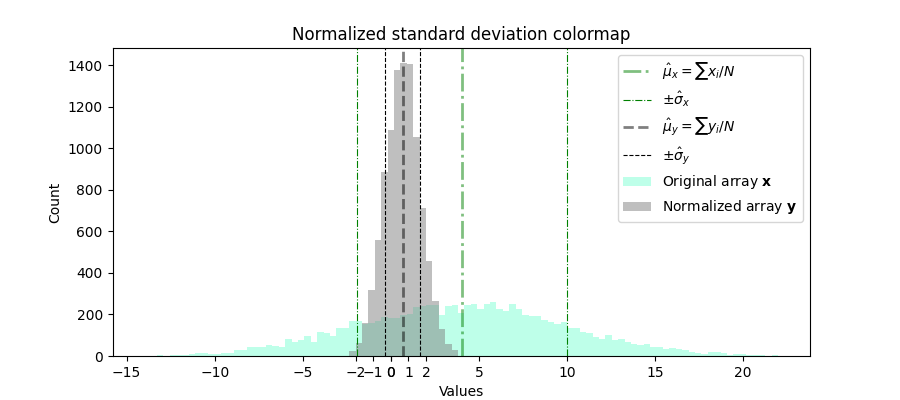

In [42]:
# Set the seed and distribution parameters using your SCIPER
np.random.seed(uid)
mean = uid % 3 + 2 
std = uid % 5 + 3

# Generate random array and apply your function
# if it fails, it is likely because the code has not been vectorized
rand_arr = mean + std * np.random.randn(10000)
try:
    arr_mapped = norm_std_map(rand_arr)
except TypeError:
    print('WARNING!!\nBe sure to avoid nested loops in your answers! These are considered incorrect.')

print(f'The near-zero-level of the original array is found first at index \
{np.where(np.abs(rand_arr) == np.min(np.abs(rand_arr)))[0][0]}.\n')
print(f'The near-zero-level of the colormapped array is found first at index \
{np.where(np.abs(arr_mapped) == np.min(np.abs(arr_mapped)))[0][0]}.\n\n\
\tUse this information carefully, remember that this is a random process.')

# Extract statistics from both arrays
rand_arr_mean = rand_arr.mean(); rand_arr_std = rand_arr.std()
arr_mapped_mean = arr_mapped.mean(); arr_mapped_std = arr_mapped.std()
# Plot
plt.close('all')
# Define bins
bins = np.linspace(mean - 3 * std , mean + 3 * std, 100)
# Plot original array and statistics
plt.figure(figsize = (9, 4))
plt.hist(rand_arr, bins, alpha=0.5, color='aquamarine', label=r'Original array $\mathbf{x}$')
xticks = plt.xticks()[0]; plt.xticks(np.sort(np.hstack((xticks,[-2,-1,0,1,2]))))
plt.axvline(rand_arr_mean, color='g', linestyle='-.', alpha=0.5, linewidth=2, label=r'$\hat{\mu}_x = \sum x_i / N$')
plt.axvline(rand_arr_mean + rand_arr_std, color='g', linestyle='-.', linewidth=0.8, label=r'$\pm\hat{\sigma}_x$')
plt.axvline(rand_arr_mean - rand_arr_std, color='g', linestyle='-.', linewidth=0.8)
# Plot transformed array and statistics
plt.hist(arr_mapped, bins, alpha=0.5, color='gray', label=r'Normalized array $\mathbf{y}$')
plt.axvline(arr_mapped_mean, color='k', linestyle='dashed', alpha=0.5, linewidth=2, label=r'$\hat{\mu}_y = \sum y_i /N$')
plt.axvline(arr_mapped_mean + arr_mapped_std, color='k', linestyle='dashed', linewidth=0.8, label=r'$\pm\hat{\sigma}_y$')
plt.axvline(arr_mapped_mean - arr_mapped_std, color='k', linestyle='dashed', linewidth=0.8)
plt.legend(loc='upper right'); plt.title('Normalized standard deviation colormap')
plt.xlabel('Values'); plt.ylabel('Count'); plt.show()

Does the histogram above make sense? Make sure that the your transformation matches what we described and that everything seems to work. Now, run the next cell for some sanity tests. We will check that

 * the standard deviation of the result is $1$, and 
 * that you treated the case of a constant array (`std=0`) properly.

In [43]:
# Test if std=1
np.testing.assert_almost_equal(1, arr_mapped_std, decimal = 2,
                               err_msg = 'The standard deviation of the second array is not 1!')
# Test zero std image 
z_arr_mapped = norm_std_map(np.ones((1000)))
assert not np.any(z_arr_mapped == np.inf) or np.all(z_arr_mapped == 0.), 'You did not treat the case where the std is 0 correctly.'
print('Nice, your function passed the sanity check!')

Nice, your function passed the sanity check!


In order to apply your color-map to each coefficient of the Haar wavelet transform separately, we define the function `map_color()`, which takes as input a transformed image, the number of iterations $n$ of the transform and the color-map. Run the next cell to declare this function.

<div class = 'alert alert-info'>
    
<b>Hint:</b> Even though you do not have to code anything in the following cell, you should take a look at how we extract the regions of the wavelet transform. It might prove useful later...
</div>

In [44]:
# Applies the color_map to the wavelet transform img with n iterations
def map_color(img, n = 0, color_map = np.array):
    # This first block is to determine whether we have a raw image or the color_map
    div = 2**(n)
    # ny and nx represent the size of the LL coefficient of the last iteration of analysis
    ny, nx = np.array(img.shape) // div
    
    # Generate output array to work on
    output = np.copy(img)
    
    # First we apply the color-map to LL coefficients
    # if n = 0, we're applying the colormap to the whole image
    output[0:ny, 0:nx] = color_map(output[0:ny, 0:nx])
    # Now we will iterate through the number of WT iterations and process the other three regions for each scale
    # if n = 0, the loop will not start
    for i in range(n):
        # Apply color_map to high-frequency components
        output[0:ny, nx:2*nx] = color_map(output[0:ny, nx:2*nx])
        output[ny:2*ny, nx:2*nx] = color_map(output[ny:2*ny, nx:2*nx])
        output[ny:2*ny, 0:nx] = color_map(output[ny:2*ny, 0:nx])
        
        # Update dimensions
        nx = nx * 2
        ny = ny * 2
    return output

Run the next cell to visualize your results again, this time applying the colormap of your choice.
<div class = 'alert alert-success'>

<b>Note:</b> In the next cell, you can choose which mapping you want to use by assigning one of the color-map functions to the variable <code>color_map</code>. If you select <code>color_map = np.array</code>, no color-map will be applied. If you feel creative, you can even define your own color-map! The color-map you choose here will be used throughout the lab, but you can always come back and change it. 
</div>

In [45]:
# Choose one of the colormap functions
color_map = norm_std_map
# color_map = non_uniform_map
# color_map = np.array 

# Apply the wavelet transform to the image lowlight
lowlight_wt_1 = analysis(lowlight, analysis_lp, analysis_hp, 1)
lowlight_wt_3 = analysis(lowlight, analysis_lp, analysis_hp, 3)
# Apply the color-map
mapped_wt_1 = map_color(lowlight_wt_1, n = 1, color_map = color_map)
mapped_wt_3 = map_color(lowlight_wt_3, n = 3, color_map = color_map)
# Define parameters of viewer
image_list = [lowlight, mapped_wt_1, mapped_wt_3]
title_list = ['Original', 'Wavelet transform (n = 1)', 'Wavelet transform (n = 3)']
# Display the result
plt.close('all')
analysis_viewer = viewer(image_list, title = title_list, widgets = True)

Which one did you prefer? As you can see, both make the presence of noise more evident than using a colormap proportional to the raw wavelet transform. Remember that you can choose which one to use by assigning the function you want to the variable `color_map`.

## 2.C. Polyphase implementation of the Haar wavelet transform - Analysis (1 point) 
[Back to table of contents](#ToC_1_WT)

In this section you will implement a fast version of the Haar wavelet transform. The key insight here is that in the filterbank implementation, half the computations made in the convolutions are thrown away immediately after by downsampling. 

In a polyphase implementation, we save computations by downsampling copies of the signal with different shifts first and then applying equivalent filters. For the Haar wavelet transform, this results in the following formula (see page 8-52 in the course notes) for the one-dimensional transform

$$ 
\begin{bmatrix} 
    y_1[k] \\ y_2[k] 
\end{bmatrix} = \frac{1}{\sqrt{2}}
\begin{bmatrix}
    1 & 1 \\
    1 & -1 
\end{bmatrix} 
\begin{bmatrix} 
    x[2k] \\
    x[2k+1] 
\end{bmatrix}\,.$$

Here, $y_1[k]$ and $y_2[k]$ represent the low-pass and high-pass wavelet coefficients, and $x[k]$ represents the one-dimensional signal (a row/column of the image when doing our horizontal/vertical pass).  

This will save both code complexity and computation time.  **For 1 point**, complete the function `poly_analysis` in the next cell. The structure is very similar to the one described in the filterbank implementation ([Section 2.A](#2.A.-Filterbank-implementation-(3-points))).

<div class = 'alert alert-info'>
    
<b>Hint:</b> Note that the expression above does not necessarily need to be implemented as a matrix multiplication. 
    
<b>Hint:</b> Remember that looping through rows/columns/pixels is not allowed. As every implementation we ask you to do in Python, your implementation below should be <a href="https://en.wikipedia.org/wiki/Array_programming" >vectorized</a>.
</div>
<div class = 'alert alert-danger'>
    
<b>Note:</b> Do not use <code>ndi.convolve1d</code> here.
</div>
<div class = 'alert alert-warning'>
    
<b>Hint:</b> Depending of your implementation, you might come up across several bugs. A known one is due to Python copying mechanisms (if you assign a NumPy Array to another NumPy Array, and apply an operation to the former, the latter one will also be modified). Try wrapping suspicious assignments with <code>np.copy()</code>. For the curious, this happens because internally, NumPy mostly <a href="https://realpython.com/python-pass-by-reference/">assigns by reference instead of assigning by value</a>. 
</div>

In [46]:
def poly_analysis(img, n):
    # Get dimensions of original
    ny, nx = img.shape
    # Declare output
    output = np.copy(img)
    for i in range(n):
        # Get LL (will select the whole image the first time, and
        # the LL part of the previous iteration the next times)
        sub = np.copy(output[0:ny, 0:nx])
        
        # Store your result in the variable sub, which is incorporated
        # into output at the end of each iteration
        
        ## Horizontal transform
        # Separate even and odd horizontal coefficients
        odd_coeff = sub[:, 1::2]
        even_coeff = sub[:, ::2]
        
        # Compute y_1[k] and y_2[k] from the expression above 
        y_1 = (even_coeff + odd_coeff) / np.sqrt(2)
        y_2 = (even_coeff - odd_coeff) / np.sqrt(2)
        
        # Concatenate results to create horizontal wavelet transfrom
        sub = np.concatenate((y_1, y_2), axis=1)
        
        ## Vertical transform
        # Repeat all the steps above for the vertical transform
        odd_coeff = sub.T[:, 1::2].T
        even_coeff = sub.T[:, ::2].T
        
        y_1 = (even_coeff + odd_coeff) / np.sqrt(2)
        y_2 = (even_coeff - odd_coeff) / np.sqrt(2)
        
        sub = np.concatenate((y_1, y_2), axis=0)
        
        output[0:ny, 0:nx] = sub 
        # Adjust dimensions of LL coefficient
        nx = nx//2
        ny = ny//2
        
    return output

You are really becoming an expert on wavelet transforms! As an initial visual test, we will almost copy-paste the cell you had right after the filterbank implementation (*spoiler:* the result should be the same, except that now we are using the visualization you selected). Then, as promised, we will run numerical tests in the next section. 

Run the next cell to plot the result of the function `poly_analysis` applied to the image lowlight. 

In [47]:
# Now we apply the Wavelet Transform to the image lowlight
lowlight_wt_1 = poly_analysis(lowlight, 1)
lowlight_wt_3 = poly_analysis(lowlight, 3)
# Apply the color-map
mapped_wt_1 = map_color(lowlight_wt_1, n = 1, color_map = color_map)
mapped_wt_3 = map_color(lowlight_wt_3, n = 3, color_map = color_map)
# Display the results
plt.close('all')
view = viewer([mapped_wt_1, mapped_wt_3], title = ['Wavelet transform - Polyphase (n = 1)', 'Wavelet transform - Polyphase (n = 3)'], widgets = True)

If you feel confident about both your implementations, we have a test to check that the polyphase formulation is in fact faster than the filterbank implementation.

Run the next cell to see the difference averaged over $10$ runs.

On average, the polyphase implementation is 2.03 times faster than the standard filterbank across the different scales.


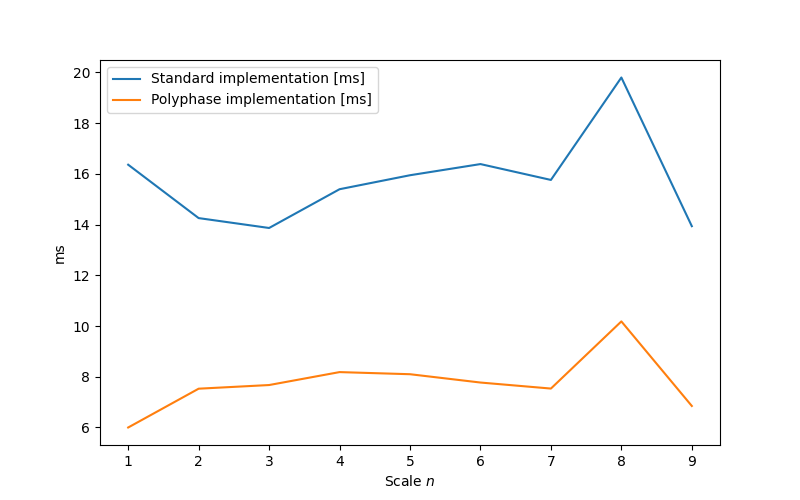

In [48]:
scales = np.arange(1,10,dtype=np.float32)
time_poly = np.zeros_like(scales); time_filterbank = np.zeros_like(scales)
reps = 10
# Run test
for n in scales:
    for i in range(reps):
        # Measure polyphase time
        start = time.time()
        poly = poly_analysis(doisneau, int(n))
        end = time.time()
        time_poly_run = end - start
        # Measure filterbank time
        start = time.time()
        filterbank = analysis(doisneau, analysis_lp, analysis_hp, int(n))
        end = time.time()
        time_filterbank_run = end - start
        # Update times
        time_poly[int(n)-1] += time_poly_run/reps
        time_filterbank[int(n)-1] += time_filterbank_run/reps

plt.close("all")
plt.figure(figsize=[8,5])
plt.plot(scales, 1000*time_filterbank, label="Standard implementation [ms]")
plt.plot(scales, 1000*time_poly, label="Polyphase implementation [ms]")
plt.xlabel(r"Scale $n$"); plt.ylabel(r"ms")
plt.legend();

print(f"On average, the polyphase implementation is {np.mean(time_filterbank)/np.mean(time_poly):.2f} times faster \
than the standard filterbank across the different scales.")

## 2.D. PyWavelets - Analysis (1 point)
[Back to table of contents](#ToC_1_WT)

To finish this section, we will show you how to do this step with PyWavelets (please refer to the [documentation](https://pywavelets.readthedocs.io/en/latest/) for a complete reference) and provide numerical tests for both your implementations.  The functions we will be using are [`pywt.dwt2`](https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#single-level-dwt2) and [`pywt.idwt2`](https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#single-level-idwt2), which stand for discrete wavelet transform and inverse discrete wavelet transform in 2D. The basic syntax of `pywt.dwt2` is

```python
cA, (cV, cH, cD) = pywt.dwt2(data, wavelet = 'haar', mode = 'periodization')
```

The parameters are
* `data`: the image,
* `wavelet` (a string): which wavelet to use (find [here](https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families) a list of the available wavelets),
* `mode`: we will use `'periodization'` (which corresponds to `'wrap'` in `ndi.convolve1d` as explained in [Section 1](#1.-The-Haar-wavelet-transform)). This is the only mode that ensures that we can have a perfect synthesis (see [options](https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes)). The default `mode` is `'symmetric'`, so make sure to always change it.

The output is the four components of the image, split in two objects,
* `cA`: "approximation", the low frequencies in both directions (which we call *LL*), and
* `(cV, cH, cD)`, a length-3 tuple that contains three images,
    * `cV`: "vertical component", the high frequencies in the vertical axis (which we call *LH*),
    * `cH`: "horizontal component", the high frequencies in the horizontal axis (which we call *HL*),
    * `cD`: "diagonal component", the high frequencies on both axis (which we call *HH*).

Note that the correct way to extract the individual sections of the coefficients is as written in the "basic syntax" of `pywt.dwt2`. In order to match the results of your functions `analysis()` and `poly_analysis()`, one needs to construct the array

$$ \begin{bmatrix} \mathrm{cA} & \mathrm{cH} \\ \mathrm{cV} & \mathrm{cD} \end{bmatrix}\,.$$

In the next cell, we will provide the function `pywt_analysis(img, n, wavelet)` which will perform $n$ iterations of the wavelet transform using PyWavelets and outputs a single image consistent with your previous results. Thus, the parameters are

* `data`: the image,
* `n`: order of the wavelet transform,
* `wavelet` (string): which wavelet to use (find [here](https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families) a list of the available wavelets).

Run the next cell to declare this function and apply it to the image `lowlight` for $n = 1$, and $n = 3$.  Explore the results visually.

In [49]:
# Function that performs n iterations of the wavelet transform on img using PyWavelets
def pywt_analysis(img, n, wavelet):
    # Extract image shape
    ny, nx = img.shape
    output = np.copy(img)
    for i in range(n):
        # Extract image or LL coefficients
        sub = output[0:ny, 0:nx]
        # Get analysis coefficients with PyWavelets
        cA, (cV, cH, cD) = pywt.dwt2(sub, wavelet=wavelet, mode='periodization')
        # Update size of LL coefficients
        nx = nx//2
        ny = ny//2
        # Fill output with results
        output[0:ny, 0:nx] = cA
        output[ny:2*ny, 0:nx] = cV
        output[0:ny, nx:2*nx] = cH
        output[ny:2*ny, nx:2*nx] = cD
    return output

# Apply the analysis and color-map
lowlight_wt_1 = pywt_analysis(lowlight, 1, 'haar')
lowlight_wt_1 = map_color(lowlight_wt_1, n = 1, color_map = color_map)
lowlight_wt_3 = pywt_analysis(lowlight, 3, 'haar')
lowlight_wt_3 = map_color(lowlight_wt_3, n = 3, color_map = color_map)

# Display the results
plt.close('all')
view = viewer([lowlight_wt_1, lowlight_wt_3], title = ['Wavelet transform - PyWavelets (n = 1)', 'Wavelet transform - PyWavelets (n = 3)'], widgets = True)

Now, you will get the final test for both implementations, an element-wise comparison of the output of `analysis`, `poly_analysis` and `pywt_analysis`, up to the $10^{th}$ decimal (so yeah, equal). Moreover, the filterbank implementation will also be tested on the Daubechies 2 wavelet (DB2) - we define the appropriate filters in the same cell. If the following cell runs without any error, congratulations, your implementations match the results of PyWavelets!

In case your implementation is not correct, the next cell will also plot the wrong results. To get a hint on where you went wrong, we are using the *compare* function of ImageViewer. Look for the red regions in the images for details (these regions are where your results and PyWavelets' differ). Note that you can activate the comparison again after changing images by clicking on `Options` $\rightarrow$ `Compare`.

<div class = 'alert alert-danger'>
    
<b>Note:</b> As usual, the fact that this cell runs does not guarantee the points.
</div>

If you see these red regions and need to debug your implementation, you can go back to [section 2.A](#filt_impl_anal) (filterbank implementation) or [section 2.C](#2.C.-Polyphase-implementation-of-the-Haar-wavelet-transform---Analysis-(1-point)) to debug!

In [50]:
# Define n
n = 2

## Test Haar
# Get the results of the three wavelet transform implementations
lighthouse_pywt = pywt_analysis(lighthouse, n, 'haar')
lighthouse_poly = poly_analysis(lighthouse, n)
lighthouse_filt = analysis(lighthouse, analysis_lp, analysis_hp, n)

# Test polyphase implementation
error_haar = False
try:
    np.testing.assert_array_almost_equal(lighthouse_pywt, lighthouse_poly, decimal = 10)
except Exception as e:
    print('Your polyphase implementation is not correct. Look at the following message for details.\n')
    print(e)
    error_haar = True
    plt.close('all')
    viewer([lighthouse_poly,lighthouse_pywt],
           title = ["Polyphase", "PyWavelets (Ground truth)"], compare = True, widgets = True)

# Test standard filterbank implementation
try:
    np.testing.assert_array_almost_equal(lighthouse_pywt, lighthouse_filt, decimal = 10)
except Exception as e:
    print('Either your filterbank implementation is not correct, or your Haar filters are not correct (check the \
           test with DB2 filters to know for sure). Look at the following message for details.\n')
    error_haar = True
    print(e)
    viewer([lighthouse_filt, lighthouse_pywt],
           title = ["Filterbank Implementation", "PyWavelets (Ground truth)"], compare = True, widgets = True)
        
## Test DB2
# Set the coefficients 
a = (1 + np.sqrt(3))/(4*np.sqrt(2)); b = (3 + np.sqrt(3))/(4*np.sqrt(2))
c = (3 - np.sqrt(3))/(4*np.sqrt(2)); d = (1 - np.sqrt(3))/(4*np.sqrt(2))
# Define the filters
analysis_lp_db2  = np.array([d, c, b, a, 0]);  analysis_hp_db2 = np.array([-a, b, -c, d, 0])
synthesis_lp_db2 = np.array([0, a, b, c, d]); synthesis_hp_db2 = np.array([0, d, -c, b, -a])

# Test
error_db = False
lighthouse_filt_db2 = analysis(lighthouse, analysis_lp_db2, analysis_hp_db2, n = n)
lighthouse_pywt_db2 = pywt_analysis(lighthouse, n, 'db2')
try:
    np.testing.assert_array_almost_equal(lighthouse_filt_db2, lighthouse_pywt_db2, decimal = 10)
    if error_haar:
        print('Your filterbank implementation is correct, but you should check your Haar filters.')        
except Exception as e:
    print('Your filterbank implementation is not correct. Look at the following message for details.\n')
    print(e)
    error_db = True
    viewer([lighthouse_filt_db2,lighthouse_pywt_db2], title = ["Filterbank (DB2)", "PyWavelets (Ground truth)"], 
           compare = True)

if not(error_db or error_haar):
    print('Congratulations! You are as good as the most accepted wavelet library in Python.')

Congratulations! You are as good as the most accepted wavelet library in Python.


To finish this section, we want you to play with the maximum scale $n$, the colormap applied, and the selection of wavelet used in the analysis. We will use the function we defined previously, `pywt_analysis()`, and extra widgets in the **ImageViewer** to do this.


<div class="alert alert-success">
    
<b>Note:</b> We didn't list all the available wavelets, of course! To get a detailed description of the wavelets available by PyWavelets, you can go to <a href="http://wavelets.pybytes.com/wavelet/db4/">this site</a> of the PyWavelets documentation. Note that we didn't cover every one of them in the course! Moreover, the site by PyWavelets can be overwhelming. For a quick overview of each of the families, Mathworks has <a href="https://www.mathworks.com/help/wavelet/gs/introduction-to-the-wavelet-families.html">this</a> very good introduction, and <a href="https://www.mathworks.com/help/wavelet/ug/wavelet-families-additional-discussion.html">this</a> also very good additional discussion. 
    
If you are interested in exploring the wavelet transform for time series and other one-dimensional data, you can also look at <a href="http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/">this post</a> for a practically-oriented introduction to wavelets with Python. 
    
Finally, if you want to go further into the topic, your course notes have a lot of academic material. Furthermore, you can check out the series of <a href="http://bigwww.epfl.ch/tutorials/index.html?k=wavelets">books, talks and tutorials</a> by the Biomedical Imaging Group, which cover from the theory of wavelets to numerous applications in image denoising (that you will also do in the second part of the lab) and reconstruction.
</div>

In particular, we have added
* the *n* slider: a slider to choose the number of scales,
* the wavelet dropdown menu: a menu to choose among several wavelet transforms to apply,
* the `Mapping` dropdown menu: a dropdown menu to choose whether (and which) colormap to use to enhance the visualization of the coefficients, and
* the button `Analysis` to apply your selection.

Remember to go the the menu `Extra Widgets` to access the options described above.

In [51]:
n_slider = widgets.IntSlider(value = 1, min = 0, max = 5, step = 1, description = 'n') 
wt_menu = widgets.Dropdown(options = ['haar', 'db2', 'db10', 'bior1.3', 'bior6.8', 'rbio1.3', 'dmey'], 
                                value = 'haar', description = 'WT:')
mapping_menu = widgets.Dropdown(options = ['None', 'Normalize std', 'Non-uniform map'], 
                                value = 'None', description = 'Mapping:')
button = widgets.Button(description = 'Analysis')

def wavelet_callback(img):
    n = n_slider.value
    wt = wt_menu.value
    output = pywt_analysis(img, n, wt)
    if mapping_menu.value == 'None':
        output = map_color(output, n = n, color_map = np.array)
    elif mapping_menu.value == 'Normalize std':
        output = map_color(output, n = n, color_map = norm_std_map)
    else:
        output = map_color(output, n = n, color_map = non_uniform_map)
    return output

wavelet_viewer = viewer(mer_de_glace, title = "WT Analysis", 
                        new_widgets = [n_slider, wt_menu, mapping_menu, button], 
                        callbacks = [wavelet_callback], widgets = True)

If you want to experiment with different images, orders, etc., use the next cell and recycle any code you want! This may also help you answer the multiple choice question below.

### Multiple choice question

To finish this section, answer the next *MCQ*, **worth 1 point**.

* Q1: After experimenting with these wavelets on different images, you probably have a pretty good idea of how the typical wavelet coefficients look. How does the wavelet transform of a white noise image look?
    
    1. The LL coefficients have much higher values than all the others, as usual.
    2. The HH coefficients have much higher values than all the others, because uncorrelated random noise contains extremely high frequencies.
    3. The LL, LH, HL, and HH coefficients have similar values because white noise is spread equally across frequencies.
    4. The LH and HL coefficients have lower values than the LL and HH coefficients, because random diagonal frequency components (high or low frequency) are very unlikely.
    
In the next cell, modify the variable `answer` to reflect your answers. The following cells is for you to check that your answer is valid.

In [52]:
# Modify the variable answer
answer = 3
# YOUR CODE HERE

In [53]:
# Sanity check
if not answer in [1, 2, 3, 4]:
    print('WARNING!!\nChoose one of 1, 2, 3 or 4. ')

# 3. Synthesis (3 points)
[Back to table of contents](#ToC_1_WT)

Now that you know how to implement the analysis or direct wavelet transform, it is time to get to the synthesis or inverse wavelet transform. In this section, you will first complete the standard filterbank implementation (upsampling followed by filtering), then you will complete the polyphase implementation of the Haar wavelet transform, and finally we will test both implementations against the implementation included in PyWavelets.

## 3.A. Filterbank implementation - Synthesis (2 points)
[Back to table of contents](#ToC_1_WT)

Now, **for 2 points** you will have to complete the function `synthesis` in Python. The parameters are
* `coeffs`: a wavelet transform,
* `lp`: the low-pass synthesis filter,
* `hp`: the high-pass synthesis filter,
* `n`: the number of iterations required to reconstruct the original image,

and the output is
* `image`: the synthesis of an image from its wavelet coefficients.

<div class = 'alert alert-success'>
    
<b>Hints:</b>
    
The structure of the `synthesis` function is very similar to the `analysis` one:
<ol>
 <li> First we get information about the size of the <i>LL</i> coefficient, and preallocate space for the output. </li>
 <li> We repeat, a total of $n$ times</li>
    <ol>
     <li> Select the appropriate region of the image (the wavelet transform coefficients for the last scale, thereafter the next scales),</li>
     <li> split the image horizontally and upsample each piece,</li>
     <li> apply the corresponding horizontal filter to each piece using `ndi.convolve1d`, </li>
     <li> add up the results to get the horizontal synthesis,</li>
     <li> repeat steps B to D for the vertical direction.</li>
</ol></ol>
     
For upsampling, you can again take advantage of advanced indexing in NumPy: you create a new array of the right size, and you fill every other of its positions with the image you want to upsample. You can look at the images in [Section 1.A](#1.A.-Boundary-conditions) for an idea on how the upsampling should work. Make sure to verify your ideas on a small, separate example before you move on.
    
<b>As usual, we do not accept answers that use loops to iterate through images</b>. </div>

In [159]:
# Function that performs n iterations of the inverse wavelet transform on coeffs
def synthesis(coeffs, lp, hp, n):
    # Get dimensions of the last wavelet transform
    div = 2**(n-1)
    ny, nx = np.array(coeffs.shape) // div
    
    # Declare output
    output = np.copy(coeffs)
    
    for i in range(n):
        # Extract wavelet coefficients (the smallest transform at first, then 
        # incorporating more and more coefficients)
        wt_iter = output[0:ny, 0:nx]
        
        # Store your result in the variable wt_iter, which is incorporated into
        # output at the end of each iteration
        
        ## Horizontal inverse transfrom
        # Split wt_iter into its two horizontal components
        up_lp = np.zeros((ny, nx))
        up_hp = np.zeros((ny, nx))
        
        wt_lp = wt_iter[:, :nx // 2]
        wt_hp = wt_iter[:, nx // 2:]
        
        # Upsample each component
        up_lp[:, ::2] = wt_lp
        up_hp[:, ::2] = wt_hp
        
        # Filter each component with the corresponding filter
        up_lp = ndi.convolve1d(up_lp, weights=lp, mode='wrap', axis=1)
        up_hp = ndi.convolve1d(up_hp, weights=hp, mode='wrap', axis=1)
        
        # Combine the results into one component
        wt_iter = up_lp + up_hp
        
        ## Vertical inverse transform
        # Repeat all the steps above for the vertical components (on the output
        # of the inverse horizontal transform)
        wt_lp = wt_iter[:ny // 2, :]
        wt_hp = wt_iter[ny // 2:, :]
        
        up_lp = np.zeros((ny, nx))
        up_hp = np.zeros((ny, nx))
        
        up_lp.T[:, ::2] = wt_lp.T
        up_hp.T[:, ::2] = wt_hp.T
        
        up_lp = ndi.convolve1d(up_lp, weights=lp, mode='wrap', axis=0)
        up_hp = ndi.convolve1d(up_hp, weights=hp, mode='wrap', axis=0)
        
        wt_iter = up_lp + up_hp
        
        # Replace synthesis of corresponding iteration
        output[0:ny, 0:nx] = wt_iter
        # Update dimensions for next scale
        nx = nx * 2
        ny = ny * 2  
    return output

In [160]:
test = np.arange(100).reshape((10,10))
test.T[:, ::2] = np.ones((10, 5))

First of all, as a preliminary test on your implementation, run the next cell to reconstruct the image `lowlight`. We will first decompose it using the function `pywt_analysis`, so that we only test your implementation of `synthesis`. We will plot the original and the synthesis. You can inspect them visually and look at the statistics to decide if it is correct.

Run the next cell to see this test.

In [161]:
# Apply synthesis to doisneau_wt_1py (output from analysis()))
mer_de_glace_coef = pywt_analysis(mer_de_glace, 4, 'haar')
mer_de_glace_rec = synthesis(mer_de_glace_coef, synthesis_lp, synthesis_hp, 4)

plt.close('all')
viewer([mer_de_glace_rec, mer_de_glace], title = ['Synthesis', 'Original'], widgets=True)

## 3.B Polyphase implementation of the Haar wavelet transform - Synthesis (1 point)
[Back to table of contents](#ToC_1_WT)

In this section you will implement a fast version of the inverse Haar wavelet transform based on the polyphase idea. The key insight is again that in the filterbank implementation, many of the computations made in the convolutions are multiplications by $0$. 

In a polyphase implementation, we save computations by first applying equivalent filters to the different coefficients, and then creating the output signal by upsampling and shifting them differently before adding them up. For the Haar wavelet transform, this results in the following formula (see page 8-52 in the course notes) for the one-dimensional transform

$$ \begin{bmatrix} x[2k] \\ x[2k + 1] \end{bmatrix} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}  \begin{bmatrix} y_1[k] \\ y_2[k] \end{bmatrix}\,.$$

The parameters of the function are

* `coeffs`: the coefficients of a wavelet transform, and
* `n`: the number of iterations required to reconstruct the original image,

and the output is
* `image`: the resulting image.

<div class = 'alert alert-danger'>
    
<b>Note</b> Do not use <code>ndi.convolve1d</code> nor any function from PyWavelets here.
</div>
<div class = 'alert alert-warning'>
    
<b>Hint</b> Depending of your implementation, you might come up across several bugs, such as confusing <code>nx</code> and <code>ny</code>, or getting tricked by NumPy's copying mechanisms, as we mentioned in <a href="#2.C.-Polyphase-implementation-of-the-Haar-wavelet-transform---Analysis-(1-point)">Section 2.C.</a>. Try wrapping suspicious assignments with <code>np.copy()</code>.  
</div>

In [162]:
# Function that performs n iterations of the inverse wavelet transform on img
def poly_synthesis(coeffs, n):
    # Get information about the transform (size of the last Wavelet Transform)
    div = 2**(n-1)
    ny, nx = np.array(coeffs.shape) // div
    # Generate output array to work on
    output = np.copy(coeffs)
    for i in range(n):
        # Extract wavelet coefficients (the smallest transform at first, then 
        # incorporating more and more coefficients)
        wt_iter = output[0:ny, 0:nx]
        
        # Store your result in the variable wt_iter, which is incorporated into
        # output at the end of each iteration
        
        ## Horizontal inverse transfrom
        # Split wt_iter into its two horizontal components
        up_lp = np.zeros((ny, nx))
        up_hp = np.zeros((ny, nx))
        
        wt_lp = wt_iter[:, :nx // 2]
        wt_hp = wt_iter[:, nx // 2:]
        
        # Apply filterbank matrix (calculate even and odd samples)
        up_even = (wt_lp + wt_hp) / np.sqrt(2)
        up_odd = (wt_lp - wt_hp) / np.sqrt(2)
        
        wt_iter[:, ::2] = up_even
        wt_iter[:, 1::2] = up_odd
        
        ## Vertical inverse transform
        # Repeat the steps above for the vertical components
        wt_lp = wt_iter[:ny // 2, :]
        wt_hp = wt_iter[ny // 2:, :]
        
        up_lp = np.zeros((ny, nx))
        up_hp = np.zeros((ny, nx))
        
        up_even = (wt_lp + wt_hp) / np.sqrt(2)
        up_odd = (wt_lp - wt_hp) / np.sqrt(2)
        
        wt_iter.T[:, ::2] = up_even.T
        wt_iter.T[:, 1::2] = up_odd.T

        # Replace synthesis of corresponding iteration
        output[0:ny, 0:nx] = wt_iter
        # Update dimensions for next scale
        nx = nx * 2
        ny = ny * 2
    return output

Run the next cell for a quick test on your polyphase implementation of the synthesis part of the Haar wavelet transform. We will test with the image `mer_de_glace`, and use the function `pywt_analysis` for the analysis so that we are only testing your `poly_synthesis` function, not your analysis function. We will plot the original and the synthesis.

In [163]:
# Get synthesis
mer_de_glace_wt_4 = pywt_analysis(mer_de_glace, 4, 'haar')
mer_de_glace_rec_4 = poly_synthesis(mer_de_glace_wt_4,  4)

# Display the results
plt.close('all')
view = viewer([mer_de_glace_rec_4, mer_de_glace], title = ['Synthesis (n = 4)', 'Original'], widgets = True)

## 3.C. Synthesis with PyWavelets
[Back to table of contents](#ToC_1_WT)

To finish this section, we will show you how to do this step with PyWavelets and provide numerical tests for both your synthesis  implementations. The basic syntax of `pywt.idwt2` is
```python
image = pywt.idwt2(coeffs, wavelet = 'haar', mode = 'periodization')
```

The parameters are
* `coeffs`: the exact output of `pywt.dwt2`, i.e.,  `(cA, (cV, cH, cD))` (see [Section 2.D.](#2.D.-Analysis-with-PyWavelets-(1-point))),
* `wavelet` (a string): which wavelet to use (see the options [here](https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes)). Clearly, to obtain the correct synthesis, you will need to apply the synthesis with the same wavelet you used for the analysis.
* `mode`: as explained before, we will use `'periodization'` (which corresponds to 'wrap' in `ndi.convolve1d`),

and the output is
* `image`: the resulting image.

In the next cell we will provide the function `pywt_synthesis(img, n, wavelet)`, which will perform $n$ iterations of the inverse wavelet transform. 

<div class="alert alert-info">
    
<b>Note</b> To be consistent with the course format, and in a similar way as we did in the function <code>pywt_analysis</code>, the function <code>pywt_synthesis</code> will take as input the coefficients arranged in an <i>image of the same size as the original</i>, i.e., it will be compatible with the output from one of the analysis functions you implemented. We will take care of splitting the image in its coefficients inside the function.   
</div> 

Run the next cell to declare this function and apply it to the image `lowlight` for $n = 1$, and $n = 4$.  Explore the results visually.

In [164]:
# Function that performs n iterations of the inverse wavelet transform on img
def pywt_synthesis(img, n, wavelet):
    # Get information about the transform (size of the last wavelet transform)
    div = 2**(n-1)
    ny, nx = np.array(img.shape) // div
    # Generate output array to work on
    output = np.copy(img)
        
    # Iterate through n
    for i in range(n):
        # Extract coefficients
        cA = output[0:ny//2, 0:nx//2]
        cH = output[0:ny//2, nx//2:nx]
        cV = output[ny//2:ny, 0:nx//2]
        cD = output[ny//2:ny, nx//2:nx]
        # Apply inverse transform
        sub = pywt.idwt2((cA, (cV, cH, cD)), mode = 'periodization', wavelet = wavelet)
        # Replace inverse transform in image
        output[0:ny, 0:nx] = sub
        # Update dimensions
        nx = nx * 2
        ny = ny * 2
    
    return output

# Apply the python analysis and color-map
lowlight_wt_1 = pywt_analysis(lowlight, 1, 'haar')
lowlight_rec_1 = pywt_synthesis(lowlight_wt_1, 1, 'haar')
lowlight_wt_4 = pywt_analysis(lowlight, 4, 'haar')
lowlight_rec_4 = pywt_synthesis(lowlight_wt_4, 4, 'haar')

# Display the results
plt.close('all')
title_list = ["Original", "Reconstruction (n=1)", "Reconstruction (n=4)"]
view = viewer([lowlight_rec_1, lowlight_rec_4, lowlight], title = title_list, widgets = True)

Great! You are pretty much done with this first notebook of the lab. Now that we have all the tools, you will get the final test for both of your implementations, an element-wise comparison of the output from `synthesis`, `poly_synthesis` and `pywt_synthesis` up to the $10^{th}$ decimal with $n = 3$. Of course, the analysis will be done using `pywt_analysis`, so that we only test the synthesis, and not the analysis. Moreover, the filterbank implementation will also be tested with the Daubechies 2 wavelet (DB2), so that in case of mistakes you can see whether your mistake is in the filters or in the synthesis functions. If the following cell runs without any error, congratulations!

<div class="alert alert-info">
    
<b>Note:</b> If there is any mistake, the next cell will also show you where the results are wrong. We will use the tool <i>compare</i> of IPLabImageViewer. Look for the red areas in the images to get a hint of where you might have gone wrong  (these areas are where your implementation and PyWavelets' differ). Note that you can activate the comparison again after changing images by clicking on <code>Options</code> $\rightarrow$ <code>Compare</code>.
</div>

If your implementations are correct, we will calculate the *signal-to-noise ratio (SNR)* (in $\mathrm{dB}$) of the synthesis with respect to the original and include it in the title. This metric measures the ratio of the power of a signal to the power of the noise (or error). The power of the signal is measured from the original image (for example, $x[l,k]$), and the noise can be measured from the difference between the original image and the reconstruction (for example, $\hat{x}[l,k]$). Therefore, the SNR is computed using the following expression

$$\operatorname{SNR}(x, \hat{x}) = \frac{\operatorname{P}_{signal}}{\operatorname{P}_{noise}} = \frac{ \sum_{l,k} x^2[l,k]}{\sum_{l,k} (x[l,k] - \hat{x}[l,k])^2} \mbox{, and } \operatorname{SNR}(x, \hat{x})~[\mathrm{dB}] = 10 \log_{10}\left(\operatorname{SNR}(x, \hat{x})\right)\,,$$

where the summation is done over all pixels. In $\mathrm{dB}$, a value of $0$ means that we have more signal than noise, and the higher the SNR the better. Pay attention to it!

<div class = 'alert alert-danger'>

<b>Note:</b> As usual, the fact that this cell runs does not guarantee the points.
</div>

Run the next cell to apply the tests with the image `lighthouse`. 

In [ ]:
# Define n
n = 3

## Checking results for Haar wavelet transform
# Get Haar wavelet transform
lighthouse_wt = pywt_analysis(lighthouse, n, 'haar')

# Get the three reconstructions (PyWavelets, generic filterbank, polyphase)
lighthouse_rec_pywt = pywt_synthesis(lighthouse_wt, n, 'haar')
lighthouse_rec_poly = poly_synthesis(lighthouse_wt, n)
lighthouse_rec_filt = synthesis(lighthouse_wt, synthesis_lp, synthesis_hp, n)

# Close all viewers
plt.close('all')

# Initialize flag to see if there are problems with the Haar wavelet results
error_haar = False; error_haar_filt = False
# Check polyphase implementation of Haar wavelet transform
try:
    np.testing.assert_array_almost_equal(lighthouse_rec_poly, lighthouse_rec_pywt, decimal = 10)
except Exception as e:
    print('Your polyphase implementation is not correct. Look at the following message for details.\n')
    print(e)
    error_haar = True
    viewer([lighthouse_rec_poly, lighthouse_rec_pywt], 
           title = ["Polyphase (Haar)", "PyWavelets (Ground truth)"], compare = True, widgets = True)
    
# Check generic filterbank implementation of Haar wavelet transform     
try:
    np.testing.assert_array_almost_equal(lighthouse_rec_filt, lighthouse_rec_pywt, decimal = 10)
except Exception as e:
    print('Either your filterbank implementation is not correct, or your Haar filters are not (check the test with \
            DB2 filters to know for sure). Look at the following message for details.\n')
    print(e)
    error_haar = True; error_haar_filt = True
    viewer([lighthouse_rec_filt, lighthouse_rec_pywt], 
           title = ["Filterbank (Haar)", "PyWavelets (Ground truth)"], compare = True, widgets = True)
    
## Checking results for DB2 wavelet transform
# Set the coefficients 
a = (1 + np.sqrt(3))/(4*np.sqrt(2)); b = (3 + np.sqrt(3))/(4*np.sqrt(2))
c = (3 - np.sqrt(3))/(4*np.sqrt(2)); d = (1 - np.sqrt(3))/(4*np.sqrt(2))
# Define the filters
analysis_lp_db2  = np.array([d, c, b, a, 0]);  analysis_hp_db2 = np.array([-a, b, -c, d, 0])
synthesis_lp_db2 = np.array([0, a, b, c, d]); synthesis_hp_db2 = np.array([0, d, -c, b, -a])

# Get DB2 wavelet transform
lighthouse_wt = pywt_analysis(lighthouse, n, 'db2')

# Get the two reconstructions (PyWavelets, generic filterbank)
lighthouse_rec_filt_db2 = synthesis(lighthouse_wt, synthesis_lp_db2, synthesis_hp_db2, n)
lighthouse_rec_pywt_db2 = pywt_synthesis(lighthouse_wt, n, 'db2')

# Initialize flag to see if there are problems with the DB2 wavelet results
error_db = False
# Check generic filterbank implementation of DB2 wavelet transform
try:
    np.testing.assert_array_almost_equal(lighthouse_rec_filt_db2, lighthouse_rec_pywt_db2, decimal = 10)
    if error_haar_filt:
        print('Your filterbank implementation is correct, but you should check your Haar filters.')
except Exception as e:
    print('Your filterbank implementation is not correct. Look at the following message for details.\n')
    print(e)
    error_db = True
    viewer([lighthouse_rec_filt_db2, lighthouse_rec_pywt_db2], 
           title = ["Filterbank (DB2)", "PyWavelets (Ground truth)"], compare = True, widgets = True)

# If everything is correct, we want the SNR in the title of each image
def snr_db(orig, img):
    snr = 10*np.log10(np.sum(orig**2)/np.sum((img - orig)**2))
    return snr 

if not(error_db or error_haar):
    print('Congratulations! You are as good as the most accepted wavelet library in Python. Now, let\'s look \
at the quality of the synthesis for the different methods using the SNR.')
    image_list = [lighthouse_rec_pywt, 
                  lighthouse_rec_poly, 
                  lighthouse_rec_filt, 
                  lighthouse_rec_pywt_db2,
                  lighthouse_rec_filt_db2,
                  lighthouse]

    titles = [f'PyWT (Haar, SNR = {np.round_(snr_db(lighthouse, lighthouse_rec_pywt), decimals=2)} dB)', 
              f'Polyphase (Haar, SNR = {np.round_(snr_db(lighthouse, lighthouse_rec_poly), decimals=2)} dB)',
              f'Filterbank (Haar, SNR = {np.round_(snr_db(lighthouse, lighthouse_rec_filt), decimals=2)} dB)',
              f'PyWT (DB2, SNR = {np.round_(snr_db(lighthouse, lighthouse_rec_filt_db2), decimals=2)}) dB', 
              f'Filterbank (DB2, SNR = {np.round_(snr_db(lighthouse, lighthouse_rec_pywt_db2), decimals=2)} dB)',
              'Original']

    plt.close('all')
    wavelet_viewer = viewer(image_list, title = titles, widgets = True)

Did you reflect on the values of the SNR? As an experiment, we will start eliminating a fixed percentage of the smallest elements of the wavelet coefficients. As you will see later in the course, each image transform has a different curve of the *SNR vs the percentage of coefficients kept* for every type of image.    

We will plot this curve for your functions and the PyWavelets implementation. If your implementation is completely correct, the curves should be almost indistinguishable. Look at the comments in the next cell for a thorough explanation. We will use the image `doisneau` and $n = 2$.

In [ ]:
# Define compression rates to test
compression_rates = [0.1, 0.3, 0.5,  1, 3, 5, 10, 20, 30, 50, 60]

# Define compression function 
def compress(img, per):
    output = np.copy(img)
    # Get the value of  the threshold
    T = np.percentile(np.abs(output), 100-per)
    # Set to zero all the pixels below the threshold
    output[np.abs(output) < T] = 0
    return output

# Initialize varible to store SNRs
snrs_poly = np.empty_like(compression_rates)
snrs_filt = np.empty_like(compression_rates)
snrs_pywt = np.empty_like(compression_rates)
# Pre-compute wavelet transforms
wt_poly = poly_analysis(doisneau, 1)
wt_filt = analysis(doisneau, analysis_lp, analysis_hp, 1)
wt_pywt = pywt_analysis(doisneau, 1, 'haar')
# Iterate through compression rates
for idx, per in enumerate(compression_rates):
    # compress and reconstruct with polyphase formulation. Get SNR
    comp_poly = compress(wt_poly, per)
    rec_poly = poly_synthesis(comp_poly,1)
    snrs_poly[idx] = snr_db(doisneau, rec_poly)
    # compress and reconstruct with filterbanks. Get SNR
    comp_filt = compress(wt_filt, per)
    rec_filt = synthesis(comp_filt, synthesis_lp, synthesis_hp, 1)
    snrs_filt[idx] = snr_db(doisneau, rec_filt)
    # compress and reconstruct with pywt. Get SNR
    comp_pywt = compress(wt_pywt, per)
    rec_pywt = pywt_synthesis(comp_pywt, 1, 'haar')
    snrs_pywt[idx] = snr_db(doisneau, rec_pywt)

# Close existing figures and initialize a new one
plt.close('all')
plt.figure(figsize = [10, 7])
ax = plt.gca()
# Declare lines. Store in variable p to add legends later
p = plt.plot(compression_rates, snrs_poly, 'r-o', 
             compression_rates, snrs_filt, 'b--o', 
             compression_rates, snrs_pywt, 'g:o')

# Make log scale
plt.xscale('log')
plt.xticks([0.1, 0.5, 1, 5, 10, 50, 100])
plt.xlabel('% of coefficients kept')
plt.ylabel('SNR [dB]')
plt.title('SNR [dB] vs % of coefficients kept')
ax.grid(which = 'both')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend(p, ['Polyphase', 'Filterbank', 'PyWT (Ground truth)'], fontsize =  10)
plt.show()

<div class="alert alert-info">

<b>Note:</b> If you really enjoyed this notebook, you love wavelets and want to keep exploring the topic, use the following cell to play around! We have included a widget with several functionalities (visualizing both the wavelet transform and the reconstruction with different colormaps, values of $n$, and different wavelet families), all using PyWavelets. Feel free to change or add any code! 
</div>

In [ ]:
n_slider = widgets.IntSlider(value = 1, min = 0, max = 4, step = 1, description = 'n') 
wt_menu = widgets.Dropdown(options = ['haar', 'db2', 'db10', 'bior1.3', 'bior6.8', 'rbio1.3', 'dmey'], 
                                value = 'haar', description = 'WT:')
mapping_menu = widgets.Dropdown(options = ['None', 'Normalize Std Dev', 'Non-Uniform Mapping'], 
                                value = 'None', description = 'Mapping:')
mode_menu = widgets.Dropdown(options = ['WT', 'iWT'], 
                                value = 'WT', description = 'Mode')
button = widgets.Button(description = 'Apply')

def wavelet_callback(img):
    n = n_slider.value
    wt = wt_menu.value
    output = pywt_analysis(img, n, wt)
    if mode_menu.value == 'WT':
        if mapping_menu.value == 'None':
            output = map_color(output, n = n, color_map = np.array)
        elif mapping_menu.value == 'Normalize Std Dev':
            output = map_color(output, n = n, color_map = norm_std_map)
        else:
            output = map_color(output, n = n, color_map = non_uniform_map)
    else:
        output = pywt_synthesis(output, n, wt)
    return output


plt.close('all')
wavelet_viewer = viewer(lighthouse, title = "WT Analysis", 
                        new_widgets = [n_slider, wt_menu, mapping_menu, mode_menu, button], 
                        callbacks = [wavelet_callback], widgets = True)

<div class="alert alert-success">
    
<p><b>Congratulations on finishing the first part of the Wavelets lab!</b></p>
<p>
Make sure to save your notebook (you might want to keep a copy on your personal computer) and upload it to <a href="https://moodle.epfl.ch/mod/assign/view.php?id=1148687">Moodle</a>, in a zip file with other notebooks of this lab.
</p>
</div>

* Keep the name of the notebook as: *1_Wavelet_transform.ipynb*,
* Name the zip file: *Wavelets_lab.zip*.

<div class="alert alert-danger">
<h4>Feedback</h4>
    <p style="margin:4px;">
    This is the first edition of the image-processing laboratories using Jupyter Notebooks running on Noto. Do not leave before giving us your <a href="https://moodle.epfl.ch/mod/feedback/view.php?id=1148686">feedback here!</a></p>
</div>